# Comparison of Optimization Algorithms in Linear Regression

#### Code for AM207 Final Project

I note that some output is still in this file, such as the iterations in the CMA-ES algorithm and 1 of the differential evolution algorithms. The PSO algorithm was ran by my partner, so the full output was not displayed here. The polynomial and simple linear regression differential evolution algorithm accidentally was removed, we accidentally re-ran the code cell and it got removed. We ended up not running it again since we already had the CSV file saved from its last run, which took over 2 hours to complete for the polynomial case. We collaborated on a colab notebook then downloaded the ipynb file. In this ipynb file we tested some of the code again after we downloaded everything which is why some cells are filled.

We decided to keep the output for the 5 cases we had though since it could show how the algorithm worked and converged to the solution. We note that the output for the algorithms slightly differs, the CMA-ES algorithm outputs the default from the function whereas we wrote manual output for DE/PSO when they converged.

All the results are on the csv files we created and stored on github so we could reproduce the results.

**Table of contents**<a id='toc0_'></a>    
- [CSV Code](#toc1_)  
- [Algorithms](#toc2_)    
  - [CMA-ES](#toc2_1_)    
  - [Differential Evolution (DE)](#toc2_2_)    
  - [Particle Swarm Optimization (PSO)](#toc2_3_)    


Imports:

In [2]:
import pandas as pd
import numpy as np
import math
import time
import random
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import cma

Fetch the California Housing Data:

In [2]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target

Install the cma library:

In [3]:
pip install cma

Note: you may need to restart the kernel to use updated packages.


# <a id='toc1_'></a>[CSV Code](#toc0_)

This code converts the lists of times, iterations, and MSEs from each optimization algorithm to csv files.

In [30]:
def convert_to_csv(time_50, iteration_50, mse_50, time_100, iteration_100, mse_100, algorithm, dimension):
  """
  Converts time, iteration, and MSE data for 50 and 100 population size to csv files.

  Parameters:
    time_50 (list): List of times for population size 50 iterations.
    iteration_50 (list): List of iterations for population size 50 iterations.
    mse_50 (list): List of MSE values for population size 50 iterations.
    time_100 (list): List of times for population size 100 iterations.
    iteration_100 (list): List of iterations for population size 100 iterations.
    mse_100 (list): List of MSE values for population size 100 iterations.
    algorithm (str): Name of algorithm being used.
    dimension (str): Dimension of the problem ('SLR', 'MLR', 'Poly').
  """
  # This finds the max length of any trial in the mse list, which is the max number of any trial in this list
  # so that we have all mse list paths are the same length (for plotting purposes and csv file since no columns can be longer
  # than another)
  max_length = max(len(trial) for trial in mse_50)

  # This loop makes it so that trials which had shorter lengths than others, shorter than max_length, it is padded with the last
  # value in that trial repeatedly since it has already converged. Again, this is for dataframe and csv file purposes.
  mses_added = []
  for trial in mse_50:
      if len(trial) < max_length:
          trial = trial + [trial[-1]] * (max_length - len(trial))
      mses_added.append(trial)

  mses_added = np.array(mses_added)

  # Takes the mean and standard deviations of the mse lists.
  average_values_50 = np.mean(mses_added, axis=0)

  std_deviation_50 = np.std(mses_added, axis=0)

  # Same as the code for population size 50, now for 100.
  max_length_100 = max(len(trial) for trial in mse_100)

  mses_added_100 = []
  for trial in mse_100:
      if len(trial) < max_length_100:
          trial = trial + [trial[-1]] * (max_length_100 - len(trial))
      mses_added_100.append(trial)

  mses_added_100 = np.array(mses_added_100)

  average_values_100 = np.mean(mses_added_100, axis=0)

  std_deviation_100 = np.std(mses_added_100, axis=0)

  # Creates dataframes for times and iterations. Includes both population sizes
  df_time_iteration = pd.DataFrame({
      'Times_50': time_50,
      'Iterations_50': iteration_50,
      'Times_100': time_100,
      'Iterations_100': iteration_100,
  })

  # Creates dataframes for MSE and Standard deviation values for population size 50
  df_mses_50 = pd.DataFrame({
      'Mses_50': average_values_50,
      'Std_deviations_50': std_deviation_50,
  })

  # Creates dataframes for MSE and Standard deviation values for population size 100
  df_mses_100 = pd.DataFrame({
      'Mses_100': average_values_100,
      'Std_deviations_100': std_deviation_100,
  })

  # Saves csv files.
  df_time_iteration.to_csv(f'{algorithm}_{dimension}_times_iterations.csv', index=False)
  df_mses_50.to_csv(f'{algorithm}_{dimension}_mses_pop_50.csv', index=False)
  df_mses_100.to_csv(f'{algorithm}_{dimension}_mses_pop_100.csv', index=False)

# <a id='toc2_'></a>[Algorithms](#toc0_)

Here we present the code for the 3 algorithms used in this project.

# <a id='toc2_1_'></a>[CMA-ES](#toc0_)

In [32]:
def objective_function(beta, X, y):
    """
    Objective function to minimize (negative log-likelihood).

    Parameters:
        beta (array): Coefficients of the regression model.
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).

    Returns:
        Negative log-likelihood as a float.
    """
    # Calculate residuals
    residuals = y - X @ beta

    return np.mean(residuals**2)

# Define the main function to optimize beta using CMA-ES
def cma_es_mlr(X, y, poly = False, n_samples=1000, tolerance=0.1, sigma_tolerance = 0.1, degree=2, popsize = 10):
    """
    Use CMA-ES to find the optimal beta coefficients for MLR with tolerance-based stopping.

    Parameters:
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).
        poly (boolean): Boolean value indicating whether to include polynomial features. Default set to False
        n_samples (int): Number of samples for algorithm to run. (Default 1000) We ended up not using this variable in the code.
        tolerance (float): Tolerance level for convergence, how far away mean in CMA-ES should be to true beta coefficients. Default set to 0.1
        sigma_tolerance (float): Tolerance level for convergence based on the step size. Default set to 0.1
        degree (int): Degree of the polynomial features. Default set to 2
        popsize (int): Population size for CMA-ES. Default set to 10

    Returns:
        Optimal beta coefficients as an array (es.mean), the number of iterations the algorithm went through as an int,
        and the list of MSE values for each iteration, all 3 returned in a tuple.
    """

    # If polynomial features is true, we add the polynomial features to the model
    if poly == True:
        poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)
        X = poly.fit_transform(X)

    # Formula to calculate the true beta values.
    X = np.column_stack([np.ones(len(X)), X])
    XTX_inv = np.linalg.inv(X.T @ X)
    true_beta = XTX_inv @ X.T @ y

    # Step 2: Initialize CMA-ES
    # The initial guess for beta coefficients, an array of zeros representing the 0 vector.
    initial_guess = np.zeros(X.shape[1])

    # Step 3: Define the CMA-ES optimizer
    es = cma.CMAEvolutionStrategy(initial_guess, 1, {'popsize': popsize})

    # Step 4: Optimize the beta coefficients
    iteration = 0
    iteration_list = []
    while not es.stop():
        # Get candidate solutions from CMA-ES
        solutions = es.ask()

        # Evaluate each candidate solution
        fitness_values = []
        for solution in solutions:
            fitness = objective_function(solution, X, y)
            fitness_values.append(fitness)
        iteration_list.append(objective_function(es.mean, X, y))

        # Tell CMA-ES the fitness value of solutions.
        es.tell(solutions, fitness_values)

        # Gets the current mean of the CMA-ES Algorithm
        best_solution = es.mean

        # Check if the difference between the current best solution and the true_beta is within the tolerance
        beta_diff = np.abs(best_solution - true_beta)

        # If the beta values are within the tolerance and the step size is small enough, break the while loop.
        if np.all(beta_diff < tolerance) and es.sigma <= sigma_tolerance:
            break

        iteration += 1

    iteration_list.append(objective_function(es.mean, X, y))
    return es.mean, iteration, iteration_list

### Run CMA-ES Algorithm

In [33]:
def run_experiment_cmaes(X, y, n_runs=30, popsize = 50, poly = False):
    """
    Function to run the experiment multiple times for different configurations

    Parameters:
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).
        n_runs (int): Number of runs for experiment. Default set to 30
        popsize (int): Population size for CMA-ES. Default set to 50
        poly (boolean): Boolean value indicating whether to include polynomial features. Default set to False

    Returns:
        List of times it took for CMA-ES to converge, list of iterations it took for CMA-ES to converge,
        and the list of MSE values for each iteration.
    """


    times = []
    iterations = []
    iterations_list = []

    for run in range(n_runs):
        start_time = time.time()  # Start time

        # Call the optimization function
        beta_optimized, num_iterations, iteration_list = cma_es_mlr(X, y, poly, n_samples=1000, tolerance=0.1,
                                                    sigma_tolerance = 0.1, degree=2, popsize = popsize)

        # Calculate time for this run
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
        iterations.append(num_iterations)
        iterations_list.append(iteration_list)


    return times, iterations, iterations_list


In [34]:
def get_results_cmaes(X, y, poly = False):
    """
    Function get the results from the CMA-ES algorithm based on different population sizes.

    Parameters:
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).
        poly (boolean): Boolean value indicating whether to include polynomial features.

    Returns:
        List across different population sizes of times it took for CMA-ES to converge, list across different population
        sizes of iterations it took for CMA-ES to converge, and the list of MSE values for each iteration. All 6 configurations
        returned as a tuple of length 6.
    """

    times_popsize_50, iterations_popsize_50, iteration_list_popsize_50 = run_experiment_cmaes(X, y, popsize=50, poly = poly)

    times_popsize_100, iterations_popsize_100, iteration_list_popsize_100 = run_experiment_cmaes(X, y, popsize=100, poly = poly)

    return times_popsize_50, iterations_popsize_50, iteration_list_popsize_50, times_popsize_100, iterations_popsize_100, iteration_list_popsize_100


### Results for CMA-ES

Here we present the code to run the CMA-ES simulation across the population sizes and 3 dimensions for the SLR, MLR, and Polynomial cases.

##### Simple Linear Regression

In [36]:
X = df[['MedInc']]
y = df['Target']

In [ ]:
times_SLR_popsize_50, iterations_SLR_popsize_50, mses_SLR_popsize_50, times_SLR_popsize_100, iterations_SLR_popsize_100, mses_SLR_popsize_100 = get_results_cmaes(X, y)

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=454112, Fri Nov 22 18:41:38 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=413156, Fri Nov 22 18:41:43 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=388986, Fri Nov 22 18:41:49 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=370478, Fri Nov 22 18:41:53 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=371981, Fri Nov 22 18:41:56 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=362796, Fri Nov 22 18:42:00 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=328114, Fri Nov 22 18:42:06 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=347772, Fri Nov 22 18:42:10 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=461400, Fri Nov 22 18:42:14 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=446392, Fri Nov 22 18:42:18 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=479453, Fri

In [ ]:
print(f'CMA-ES Mean for time SLR model, popsize 50: {np.mean(times_SLR_popsize_50)}')
print(f'CMA-ES Mean for iterations SLR model, popsize 50: {np.mean(iterations_SLR_popsize_50)}')
print(f'CMA-ES Mean for time SLR model, popsize 100: {np.mean(times_SLR_popsize_100)}')
print(f'CMA-ES Mean for iterations SLR model, popsize 100: {np.mean(iterations_SLR_popsize_100)}')

CMA-ES Mean for time SLR model, popsize 50: 2.0550599892934165
CMA-ES Mean for iterations SLR model, popsize 50: 29.266666666666666
CMA-ES Mean for time SLR model, popsize 100: 1.8439032395680746
CMA-ES Mean for iterations SLR model, popsize 100: 25.7


In [ ]:
convert_to_csv(times_SLR_popsize_50, iterations_SLR_popsize_50, mses_SLR_popsize_50, times_SLR_popsize_100, iterations_SLR_popsize_100, mses_SLR_popsize_100, 'CMAES', 'SLR')

In [4]:
data_CMAES_SLR = pd.read_csv('CMAES_SLR_times_iterations.csv')

# Testing csv
print(f'CMA-ES Mean for time SLR, popsize 50: {np.mean(data_CMAES_SLR['Times_50'])}')
print(f'CMA-ES Mean for iterations SLR, popsize 50: {np.mean(data_CMAES_SLR['Iterations_50'])}')
print(f'CMA-ES Mean for time SLR, popsize 100: {np.mean(data_CMAES_SLR['Times_100'])}')
print(f'CMA-ES Mean for iterations SLR, popsize 100: {np.mean(data_CMAES_SLR['Iterations_100'])}')

CMA-ES Mean for time SLR, popsize 50: 2.0550599892934165
CMA-ES Mean for iterations SLR, popsize 50: 29.266666666666666
CMA-ES Mean for time SLR, popsize 100: 1.8439032395680746
CMA-ES Mean for iterations SLR, popsize 100: 25.7


##### Multiple Linear Regression

In [37]:
X_MLR = df[['MedInc', 'AveRooms', 'AveBedrms']]

In [ ]:
times_MLR_popsize_50, iterations_MLR_popsize_50, mses_MLR_popsize_50, times_MLR_popsize_100, iterations_MLR_popsize_100, mses_MLR_popsize_100 = get_results_cmaes(X_MLR, y)

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=388223, Fri Nov 22 18:43:35 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=387135, Fri Nov 22 18:43:37 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=389512, Fri Nov 22 18:43:39 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=332347, Fri Nov 22 18:43:41 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=379698, Fri Nov 22 18:43:42 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=422148, Fri Nov 22 18:43:43 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=462720, Fri Nov 22 18:43:44 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=316741, Fri Nov 22 18:43:46 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=464141, Fri Nov 22 18:43:46 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=397831, Fri Nov 22 18:43:48 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 4 (seed=408117, Fri

In [ ]:
print(f'CMA-ES Mean for time MLR model, popsize 50: {np.mean(times_MLR_popsize_50)}')
print(f'CMA-ES Mean for iterations MLR model, popsize 50: {np.mean(iterations_MLR_popsize_50)}')
print(f'CMA-ES Mean for time MLR model, popsize 100: {np.mean(times_MLR_popsize_100)}')
print(f'CMA-ES Mean for iterations MLR model, popsize 100: {np.mean(iterations_MLR_popsize_100)}')

CMA-ES Mean for time MLR model, popsize 50: 1.3365686337153118
CMA-ES Mean for iterations MLR model, popsize 50: 32.06666666666667
CMA-ES Mean for time MLR model, popsize 100: 3.259465789794922
CMA-ES Mean for iterations MLR model, popsize 100: 40.03333333333333


In [ ]:
convert_to_csv(times_MLR_popsize_50, iterations_MLR_popsize_50, mses_MLR_popsize_50, times_MLR_popsize_100, iterations_MLR_popsize_100, mses_MLR_popsize_100, 'CMAES', 'MLR')

3.259465789794922

In [5]:
data_CMAES_MLR  = pd.read_csv('CMAES_MLR_times_iterations.csv')

# Testing csv
print(f'CMA-ES Mean for time MLR, popsize 50: {np.mean(data_CMAES_MLR['Times_50'])}')
print(f'CMA-ES Mean for iterations MLR, popsize 50: {np.mean(data_CMAES_MLR['Iterations_50'])}')
print(f'CMA-ES Mean for time MLR, popsize 100: {np.mean(data_CMAES_MLR['Times_100'])}')
print(f'CMA-ES Mean for iterations MLR, popsize 100: {np.mean(data_CMAES_MLR['Iterations_100'])}')

CMA-ES Mean for time MLR, popsize 50: 1.3365686337153118
CMA-ES Mean for iterations MLR, popsize 50: 32.06666666666667
CMA-ES Mean for time MLR, popsize 100: 3.259465789794922
CMA-ES Mean for iterations MLR, popsize 100: 40.03333333333333


##### Polynomial Regression

In [ ]:
times_Poly_popsize_50, iterations_Poly_popsize_50, mses_Poly_popsize_50, times_Poly_popsize_100, iterations_Poly_popsize_100, mses_Poly_popsize_100 = get_results_cmaes(X_MLR, y, poly=True)

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=390166, Fri Nov 22 18:45:53 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=366577, Fri Nov 22 18:45:57 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=414727, Fri Nov 22 18:46:02 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=390256, Fri Nov 22 18:46:06 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=408551, Fri Nov 22 18:46:10 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=421960, Fri Nov 22 18:46:16 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=430622, Fri Nov 22 18:46:19 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=398362, Fri Nov 22 18:46:22 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=454889, Fri Nov 22 18:46:27 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=363623, Fri Nov 22 18:46:32 2024)
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 10 (seed=

In [ ]:
print(f'CMA-ES Mean for time Polynomial model, popsize 50: {np.mean(times_Poly_popsize_50)}')
print(f'CMA-ES Mean for iterations Polynomial model, popsize 50: {np.mean(iterations_Poly_popsize_50)}')
print(f'CMA-ES Mean for time Polynomial model, popsize 100: {np.mean(times_Poly_popsize_100)}')
print(f'CMA-ES Mean for iterations Polynomial model, popsize 100: {np.mean(iterations_Poly_popsize_100)}')

CMA-ES Mean for time Polynomial model, popsize 50: 4.229007649421692
CMA-ES Mean for iterations Polynomial model, popsize 50: 85.5
CMA-ES Mean for time Polynomial model, popsize 100: 7.097780148188273
CMA-ES Mean for iterations Polynomial model, popsize 100: 71.86666666666666


In [ ]:
convert_to_csv(times_Poly_popsize_50, iterations_Poly_popsize_50, mses_Poly_popsize_50, times_Poly_popsize_100, iterations_Poly_popsize_100, mses_Poly_popsize_100, 'CMAES', 'Poly')

In [6]:
data_CMAES_Poly = pd.read_csv('CMAES_Poly_times_iterations.csv')

# Testing csv
print(f'CMA-ES Mean for time Polynomial, popsize 50: {np.mean(data_CMAES_Poly['Times_50'])}')
print(f'CMA-ES Mean for iterations Polynomial, popsize 50: {np.mean(data_CMAES_Poly['Iterations_50'])}')
print(f'CMA-ES Mean for time Polynomial, popsize 100: {np.mean(data_CMAES_Poly['Times_100'])}')
print(f'CMA-ES Mean for iterations Polynomial, popsize 100: {np.mean(data_CMAES_Poly['Iterations_100'])}')

CMA-ES Mean for time Polynomial, popsize 50: 4.229007649421692
CMA-ES Mean for iterations Polynomial, popsize 50: 85.5
CMA-ES Mean for time Polynomial, popsize 100: 7.097780148188273
CMA-ES Mean for iterations Polynomial, popsize 100: 71.86666666666666


# <a id='toc2_2_'></a>[Differential Evolution](#toc0_)

In [48]:
def mse_function(beta, X, y):
    """
    Objective function to minimize (negative log-likelihood).

    Parameters:
        beta (array): Coefficients of the regression model.
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).

    Returns:
        Negative log-likelihood (or RSS).
    """
    # Calculate residuals
    residuals = y - X @ beta
    return np.mean(residuals**2)

def initialize_population(N, D):
    """
    Initializes population for differential evolution.

    Parameters:
        N (int): Number of individuals in the population.
        D (int): Dimension of the problem (number of coefficients).

    Returns:
        Array of initialized population.
    """
    population = []
    for _ in range(N):
        # Randomly initialize the population within bounds for each parameter
        individual = np.random.uniform(low=-1, high=1, size=D)
        population.append(individual)
    return np.array(population)

# DE Mutation, Recombination, and Selection
def differential_evolution(X_d, y, N, CR = 0.9, F = 0.75, max_generations = 10000000, degree = 2, poly = False, tolerance = 0.1):
    """
    Differential Evolution Function

    Parameters:
        X_d (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).
        N (int): Number of individuals in the population.
        CR (float): Crossover rate probability between 0 and 1. Default 0.9.
        F (float): Mutation factor between 0 and 2. Default set to 0.75.
        max_generations (int): Maximum number of generations to run the algorithm. Default set to 10000000.
        degree (int): Degree of the polynomial features. Default set to 2
        poly (boolean): Boolean value indicating whether to include polynomial features. Default set to False.
        tolerance (float): Tolerence level for convergence, how far away mean of population should be to true beta coefficients. Default set to 0.1.

    Returns:
        Mean of the optimized converged population, number of iterations (generations) it took to converge,
        and the list of MSE values for each iteration as a tuple.
    """

    # If polynomial is true, create polynomial features.
    if poly:
        poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)
        X_d = poly.fit_transform(X_d)

    X_d = np.column_stack([np.ones(len(X_d)), X_d])
    XTX_inv = np.linalg.inv(X_d.T @ X_d)
    true_beta = XTX_inv @ X_d.T @ y

    D = len(true_beta)
    population = initialize_population(N, D)

    # Fit OLS to get reference coefficients
    model_Poly = LinearRegression().fit(X_d, y)

    # Compute the variance of the OLS coefficients (as a reference)
    residuals = y - model_Poly.predict(X_d)

    # Calculate sigma and obtain the variance used in the stopping criteria.
    sigma_squared = np.sum(residuals**2) / (X_d.shape[0] - X_d.shape[1])

    ols_cov_matrix = sigma_squared * XTX_inv
    ols_coeff_variance = np.diagonal(ols_cov_matrix)

    mse_list = []

    for generation in range(max_generations):
        # Evaluate fitness of each individual in the population
        fitness = np.array([mse_function(ind, X_d, y) for ind in population])

        top_50_percent_idx = np.argsort(fitness)[:int(0.5 * N)]
        top_50_percent = population[top_50_percent_idx]

        # Compute mean and variance of top 10% population
        mean_top_50 = np.mean(top_50_percent, axis=0)
        variance_top_50 = np.var(top_50_percent, axis=0)

        mse_top_50_mean = mse_function(mean_top_50, X_d, y)
        mse_list.append(mse_top_50_mean)

        # Calculate beta difference from true_beta (tolerance check)
        beta_diff = np.abs(mean_top_50 - true_beta)

        # Stopping condition based on mean and variance, print statement to output results.
        if np.all(beta_diff < tolerance) and np.all(variance_top_50 < ols_coeff_variance * 1.5):  # 50% variance threshold
            print(f"Stopping at generation {generation + 1} | Mean Individual: {mean_top_50} | Variance: {variance_top_50}")
            break


        # Create next generation
        next_population = []
        for i in range(N):
            # Mutation step: choose three distinct random indices
            r1, r2, r3 = random.sample([j for j in range(N) if j != i], 3)

            # Form donor vector
            donor_vector = population[r1] + F * (population[r2] - population[r3])

            # Recombination: trial vector, mixing target and donor
            trial_vector = np.copy(population[i])
            for j in range(D):
                if random.random() <= CR or j == random.randint(0, D-1):
                    trial_vector[j] = donor_vector[j]
            # Selection: choose the best between target and trial vector
            if mse_function(trial_vector, X_d, y) < mse_function(population[i], X_d, y):
                next_population.append(trial_vector)
            else:
                next_population.append(population[i])

        population = np.array(next_population)

    return mean_top_50, generation + 1, mse_list


# Run DE

In [49]:
# Function to run the experiment multiple times for different configurations
def run_experiment_de(X, y, n_runs=30, N = 10, poly = False):
    """
    Function to run the experiment multiple times for different configurations for the DE algorithm.

    Parameters:
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).
        n_runs (int): Number of runs for experiment. Default set to 30
        N (int): Population size for DE. Default set to 10
        poly (boolean): Boolean value indicating whether to include polynomial features. Default set to False

    Returns:
        List of times it took for DE to converge, list of iterations it took for DE to converge,
        and the list of MSE values for each iteration.
    """
    times = []
    iterations = []
    mses = []

    for run in range(n_runs):
        start_time = time.time()  # Start time

        # Call the optimization function
        beta_optimized, generation, mse = differential_evolution(X, y, N = N, poly = poly)

        # Calculate elapsed time for this run
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
        iterations.append(generation)
        mses.append(mse)


    return times, iterations, mses

In [50]:
def get_results_de(X, y, poly = False):
    """
    Function get the results from the DE algorithm based on different population sizes.

    Parameters:
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).
        poly (boolean): Boolean value indicating whether to include polynomial features. Default set to False

    Returns:
        List across different population sizes of times it took for DE to converge, list across different population
        sizes of iterations it took for DE to converge, and the list of MSE values for each iteration. All 6 configurations
        returned as a tuple of length 6.
    """
    times_popsize_50, iterations_popsize_50, mses_list_popsize_50 = run_experiment_de(X, y, N=50, poly = poly)

    times_popsize_100, iterations_popsize_100, mses_list_popsize_100 = run_experiment_de(X, y, N=100, poly = poly)

    return times_popsize_50, iterations_popsize_50, mses_list_popsize_50, times_popsize_100, iterations_popsize_100, mses_list_popsize_100


## Results for DE

##### Simple Linear Regression

In [ ]:
de_times_SLR_popsize_50, de_iterations_SLR_popsize_50, de_mses_SLR_popsize_50, de_times_SLR_popsize_100, de_iterations_SLR_popsize_100, de_mses_SLR_popsize_100 = get_results_de(X, y)

In [ ]:
print(f'Differential Evolution Mean for time SLR, popsize 50: {np.mean(de_times_SLR_popsize_50)}')
print(f'Differential Evolution Mean for iterations SLR, popsize 50: {np.mean(de_iterations_SLR_popsize_50)}')
print(f'Differential Evolution Mean for time SLR, popsize 100: {np.mean(de_times_SLR_popsize_100)}')
print(f'Differential Evolution Mean for iterations SLR, popsize 100: {np.mean(de_iterations_SLR_popsize_100)}')

Differential Evolution Mean for time SLR, popsize 50: 2.5509915510813395
Differential Evolution Mean for iterations SLR, popsize 50: 25.5
Differential Evolution Mean for time SLR, popsize 100: 4.68611056804657
Differential Evolution Mean for iterations SLR, popsize 100: 25.766666666666666


In [ ]:
convert_to_csv(de_times_SLR_popsize_50, de_iterations_SLR_popsize_50, de_mses_SLR_popsize_50, de_times_SLR_popsize_100, de_iterations_SLR_popsize_100, de_mses_SLR_popsize_100, 'DE', 'SLR')

In [7]:
data_DE_SLR = pd.read_csv('DE_SLR_times_iterations.csv')

# Testing csv
print(f'Differential Evolution Mean for time SLR, popsize 50: {np.mean(data_DE_SLR['Times_50'])}')
print(f'Differential Evolution Mean for iterations SLR, popsize 50: {np.mean(data_DE_SLR['Iterations_50'])}')
print(f'Differential Evolution Mean for time SLR, popsize 100: {np.mean(data_DE_SLR['Times_100'])}')
print(f'Differential Evolution Mean for iterations SLR, popsize 100: {np.mean(data_DE_SLR['Iterations_100'])}')

Differential Evolution Mean for time SLR, popsize 50: 2.5509915510813395
Differential Evolution Mean for iterations SLR, popsize 50: 25.5
Differential Evolution Mean for time SLR, popsize 100: 4.68611056804657
Differential Evolution Mean for iterations SLR, popsize 100: 25.766666666666666


##### Multiple Linear Regression

In [ ]:
de_times_MLR_popsize_50, de_iterations_MLR_popsize_50, de_mses_MLR_popsize_50, de_times_MLR_popsize_100, de_iterations_MLR_popsize_100, de_mses_MLR_popsize_100 = get_results_de(X_MLR, y)

Stopping at generation 75 | Mean Individual: [ 0.11140949  0.53594685 -0.23575051  1.06153727] | Variance: [5.43763502e-04 2.22546118e-05 4.37461327e-05 1.15669278e-03]
Stopping at generation 75 | Mean Individual: [ 0.10990681  0.53658489 -0.23900473  1.07609591] | Variance: [3.37278367e-04 1.75773616e-05 4.33124174e-05 9.74446605e-04]
Stopping at generation 80 | Mean Individual: [ 0.11422304  0.53406409 -0.23461567  1.06154972] | Variance: [6.00869718e-04 2.21977143e-05 4.31929667e-05 1.20610989e-03]
Stopping at generation 68 | Mean Individual: [ 0.10508685  0.53649047 -0.23889018  1.07928561] | Variance: [6.32390740e-04 1.77289352e-05 4.94601719e-05 1.30520358e-03]
Stopping at generation 67 | Mean Individual: [ 0.11890926  0.53318803 -0.23407787  1.05581986] | Variance: [4.41006686e-04 2.61130989e-05 4.77529869e-05 1.03706305e-03]
Stopping at generation 64 | Mean Individual: [ 0.11640759  0.53418458 -0.23621613  1.06621605] | Variance: [3.73441135e-04 1.73532312e-05 5.46762988e-05 1.

In [ ]:
print(f'Differential Evolution Mean for time MLR, popsize 50: {np.mean(de_times_MLR_popsize_50)}')
print(f'Differential Evolution Mean for iterations MLR, popsize 50: {np.mean(de_iterations_MLR_popsize_50)}')
print(f'Differential Evolution Mean for time MLR, popsize 100: {np.mean(de_times_MLR_popsize_100)}')
print(f'Differential Evolution Mean for iterations MLR, popsize 100: {np.mean(de_iterations_MLR_popsize_100)}')

Differential Evolution Mean for time MLR, popsize 50: 7.283486572901408
Differential Evolution Mean for iterations MLR, popsize 50: 70.3
Differential Evolution Mean for time MLR, popsize 100: 15.200251603126526
Differential Evolution Mean for iterations MLR, popsize 100: 72.4


In [ ]:
convert_to_csv(de_times_MLR_popsize_50, de_iterations_MLR_popsize_50, de_mses_MLR_popsize_50, de_times_MLR_popsize_100, de_iterations_MLR_popsize_100, de_mses_MLR_popsize_100, 'DE', 'MLR')

In [8]:
data_DE_MLR = pd.read_csv('DE_MLR_times_iterations.csv')

# Testing csv
print(f'Differential Evolution Mean for time MLR, popsize 50: {np.mean(data_DE_MLR['Times_50'])}')
print(f'Differential Evolution Mean for iterations MLR, popsize 50: {np.mean(data_DE_MLR['Iterations_50'])}')
print(f'Differential Evolution Mean for time MLR, popsize 100: {np.mean(data_DE_MLR['Times_100'])}')
print(f'Differential Evolution Mean for iterations MLR, popsize 100: {np.mean(data_DE_MLR['Iterations_100'])}')

Differential Evolution Mean for time MLR, popsize 50: 7.283486572901408
Differential Evolution Mean for iterations MLR, popsize 50: 70.3
Differential Evolution Mean for time MLR, popsize 100: 15.200251603126526
Differential Evolution Mean for iterations MLR, popsize 100: 72.4


##### Polynomial

In [ ]:
de_times_Poly_popsize_50, de_iterations_Poly_popsize_50, de_mses_Poly_popsize_50, de_times_Poly_popsize_100, de_iterations_Poly_popsize_100, de_mses_Poly_popsize_100 = get_results_de(X_MLR, y, poly= True)

In [ ]:
print(f'Differential Evolution Mean for time Poly, popsize 50: {np.mean(de_times_Poly_popsize_50)}')
print(f'Differential Evolution Mean for iterations Poly, popsize 50: {np.mean(de_iterations_Poly_popsize_50)}')
print(f'Differential Evolution Mean for time Poly, popsize 100: {np.mean(de_times_Poly_popsize_100)}')
print(f'Differential Evolution Mean for iterations Poly, popsize 100: {np.mean(de_iterations_Poly_popsize_100)}')

Differential Evolution Mean for time Poly, popsize 50: 98.83385886351267
Differential Evolution Mean for iterations Poly, popsize 50: 758.4
Differential Evolution Mean for time Poly, popsize 100: 240.01110973358155
Differential Evolution Mean for iterations Poly, popsize 100: 930.4


In [ ]:
convert_to_csv(de_times_Poly_popsize_50, de_iterations_Poly_popsize_50, de_mses_Poly_popsize_50, de_times_Poly_popsize_100, de_iterations_Poly_popsize_100, de_mses_Poly_popsize_100, 'DE', 'Poly')

In [10]:
data_DE_Poly = pd.read_csv('DE_Poly_times_iterations.csv')

# Testing csv
print(f'Differential Evolution Mean for time Polynomial, popsize 50: {np.mean(data_DE_Poly['Times_50'])}')
print(f'Differential Evolution Mean for iterations Polynomial, popsize 50: {np.mean(data_DE_Poly['Iterations_50'])}')
print(f'Differential Evolution Mean for time Polynomial, popsize 100: {np.mean(data_DE_Poly['Times_100'])}')
print(f'Differential Evolution Mean for iterations Polynomial, popsize 100: {np.mean(data_DE_Poly['Iterations_100'])}')

Differential Evolution Mean for time Polynomial, popsize 50: 98.83385886351267
Differential Evolution Mean for iterations Polynomial, popsize 50: 758.4
Differential Evolution Mean for time Polynomial, popsize 100: 240.01110973358155
Differential Evolution Mean for iterations Polynomial, popsize 100: 930.4


# <a id='toc2_3_'></a>[Particle Swarm Optimization](#toc0_)

In [ ]:
def PSO(X, y, population_size, num_generations, degree=2, poly=False, tolerance=0.1, w=0.8, c1=2, c2=2):
    """
    Runs the PSO algorithm

    Parameters:
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).
        population_size (int): number of particles
        num_generations (int): max number of training iterations
        degree (int): degree of function being fit
        poly (bool): whether we're fitting a polynomial. Defaults to False.
        tolerance (float): tolerance for coefficient estimates. Defaults to 0.1.
        w (float): momentum factor (how much velocity to preserve). Defaults to 0.8.
        c1 (float): convergence factor (towards personal best). Defaults to 2.
        c2 (float): convergence factor (towards global best). Defaults to 2.

    Returns:
      Converged mean value, number of iterations it took to converge,
      and the list of MSE values for each iteration.
    """
    if poly:
        poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)
        X = poly.fit_transform(X)

    X = np.column_stack([np.ones(len(X)), X])
    XTX_inv = np.linalg.inv(X.T @ X)
    true_beta = XTX_inv @ X.T @ y
    #print("True Beta:", true_beta)

    # Fit OLS to get reference coefficients
    model_Poly = LinearRegression().fit(X, y)

    # Compute the variance of the OLS coefficients (as a reference)
    residuals = y - model_Poly.predict(X)

    # Calculate sigma by taking the RSS and dividing by the degrees of freedom
    sigma_squared = np.sum(residuals**2) / (X.shape[0] - X.shape[1])

    ols_cov_matrix = sigma_squared * XTX_inv
    ols_coeff_variance = np.diagonal(ols_cov_matrix)

    # Initialize the particles' positions and velocities
    num_coefficients = X.shape[1]  # Number of coefficients (including intercept)
    positions = np.random.uniform(-1, 1, (population_size, num_coefficients))
    velocities = np.random.uniform(-1, 1, (population_size, num_coefficients))

    # Initialize the best personal and global positions
    personal_best_positions = positions.copy()
    personal_best_scores = np.array([float('inf')] * population_size)
    global_best_position = None
    global_best_score = float('inf')

    mse_list = []

    # PSO main loop
    for generation in range(num_generations):
        # Calculate the fitness (MSE)
        mse = np.array([mse_function(pos, X, y) for pos in positions])

        for i in range(population_size):
            # Update personal best if the current score is better
            if mse[i] < personal_best_scores[i]:
                personal_best_scores[i] = mse[i]
                personal_best_positions[i] = positions[i].copy()

            # Update global best if the current score is better
            if mse[i] < global_best_score:
                global_best_score = mse[i]
                global_best_position = positions[i].copy()

        # Update particles' velocities and positions
        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (w * velocities[i] +
                            c1 * r1 * (personal_best_positions[i] - positions[i]) +
                            c2 * r2 * (global_best_position - positions[i]))
            positions[i] += velocities[i]

        top_50_percent_idx = np.argsort(mse)[:int(0.5 * population_size)]
        top_50_percent = positions[top_50_percent_idx]

        # Compute mean and variance of top 50% population
        mean_top_50 = np.mean(top_50_percent, axis=0)
        variance_top_50 = np.var(top_50_percent, axis=0)

        mse_top_50_mean = mse_function(mean_top_50, X, y)
        mse_list.append(mse_top_50_mean)

        # Calculate beta difference from true_beta (tolerance check)
        beta_diff = np.abs(mean_top_50 - true_beta)

        # Stopping condition based on mean and variance
        if np.all(beta_diff < tolerance) and np.all(variance_top_50 < ols_coeff_variance * 1.1):  # 10% variance threshold
            print(f"Stopping early at generation {generation + 1} | Mean Individual: {mean_top_50} | Variance: {variance_top_50}")
            break

    # Final solution
    print("Best coefficients found:", global_best_position)
    print("True coefficients:", true_beta)
    return mean_top_50, generation + 1, mse_list


# Run PSO

In [ ]:
def run_experiment_pso(X, y, n_runs=30, N = 10, poly = False):
    """
    Function to run the experiment multiple times for different configurations for the PSO algorithm.

    Parameters:
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).
        n_runs (int): Number of runs for experiment. Default set to 30
        N (int): Population size for PSO.Default set to 10
        poly (boolean): Boolean value indicating whether to include polynomial features. Default set to False

    Returns:
        List of times it took for PSO to converge, list of iterations it took for PSO to converge,
        and the list of MSE values for each iteration.
    """
    times = []
    iterations = []
    mse_collection = []

    for run in range(n_runs):
        start_time = time.time()  # Start time

        # Call the optimization function
        beta_optimized, generation, mse_list = PSO(X, y, N, num_generations = 100000, poly = poly)

        # Calculate elapsed time for this run
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
        iterations.append(generation)
        mse_collection.append(mse_list)


    return times, iterations, mse_collection

In [ ]:
def get_results_pso(X, y, poly = False):
    """
    Function get the results from the PSO algorithm based on different population sizes.

    Parameters:
        X (pandas dataframe): Original feature matrix (N x p).
        y (pandas series): Target values (N x 1).
        poly (boolean): Boolean value indicating whether to include polynomial features. Default set to False

    Returns:
        List across different population sizes of times it took for PSO to converge, list across different population
        sizes of iterations it took for PSO to converge, and the list of MSE values for each iteration. All 6 configurations
        returned as a tuple of length 6.
    """
    times_SLR_popsize_50, iterations_SLR_popsize_50, mses_SLR_popsize_50 = run_experiment_pso(X, y, N=50, poly = poly)
    times_SLR_popsize_100, iterations_SLR_popsize_100, mses_SLR_popsize_100 = run_experiment_pso(X, y, N=100, poly = poly)
    return times_SLR_popsize_50, iterations_SLR_popsize_50, mses_SLR_popsize_50, times_SLR_popsize_100, iterations_SLR_popsize_100, mses_SLR_popsize_100

##### Simple Linear Regression

In [ ]:
pso_times_SLR_popsize_50, pso_iterations_SLR_popsize_50, pso_mses_SLR_popsize_50, pso_times_SLR_popsize_100, pso_iterations_SLR_popsize_100, pso_mses_SLR_popsize_100 = get_results_pso(X, y)

In [ ]:
print(f'PSO Mean for time SLR, popsize 50: {np.mean(pso_times_SLR_popsize_50)}')
print(f'PSO Mean for iterations SLR, popsize 50: {np.mean(pso_iterations_SLR_popsize_50)}')
print(f'PSO Mean for time SLR, popsize 100: {np.mean(pso_times_SLR_popsize_100)}')
print(f'PSO Mean for iterations SLR, popsize 100: {np.mean(pso_iterations_SLR_popsize_100)}')

In [43]:
data_PSO_Poly = pd.read_csv('PSO_SLR_times_iterations.csv')

print(f'PSO Mean for time SLR, popsize 50: {np.mean(data_PSO_Poly['Times_50'])}')
print(f'PSO Mean for iterations SLR, popsize 50: {np.mean(data_PSO_Poly['Iterations_50'])}')
print(f'PSO Mean for time SLR, popsize 100: {np.mean(data_PSO_Poly['Times_100'])}')
print(f'PSO Mean for iterations SLR, popsize 100: {np.mean(data_PSO_Poly['Iterations_100'])}')

PSO Mean for time SLR, popsize 50: 11.512456488609313
PSO Mean for iterations SLR, popsize 50: 312.3666666666667
PSO Mean for time SLR, popsize 100: 23.011320638656617
PSO Mean for iterations SLR, popsize 100: 322.2


##### Multiple Linear Regression

In [ ]:
pso_times_MLR_popsize_50, pso_iterations_MLR_popsize_50, pso_mses_MLR_popsize_50, pso_times_MLR_popsize_100, pso_iterations_MLR_popsize_100, pso_mses_MLR_popsize_100 = get_results_pso(X_MLR, y)

In [ ]:
print(f'PSO Mean for time MLR, popsize 50: {np.mean(pso_times_MLR_popsize_50)}')
print(f'PSO Mean for iterations MLR, popsize 50: {np.mean(pso_iterations_MLR_popsize_50)}')
print(f'PSO Mean for time MLR, popsize 100: {np.mean(pso_times_MLR_popsize_100)}')
print(f'PSO Mean for iterations MLR, popsize 100: {np.mean(pso_iterations_MLR_popsize_100)}')

In [47]:
data_PSO_MLR = pd.read_csv('PSO_MLR_times_iterations.csv')

print(f'PSO Mean for time MLR, popsize 50: {np.mean(data_PSO_MLR['Times_50'])}')
print(f'PSO Mean for iterations MLR, popsize 50: {np.mean(data_PSO_MLR['Iterations_50'])}')
print(f'PSO Mean for time MLR, popsize 100: {np.mean(data_PSO_MLR['Times_100'])}')
print(f'PSO Mean for iterations MLR, popsize 100: {np.mean(data_PSO_MLR['Iterations_100'])}')

PSO Mean for time MLR, popsize 50: 11.462143238385519
PSO Mean for iterations MLR, popsize 50: 323.3333333333333
PSO Mean for time MLR, popsize 100: 22.937596933046976
PSO Mean for iterations MLR, popsize 100: 326.3666666666667


##### Polynomial Regression

In [ ]:
pso_times_Poly_popsize_50, pso_iterations_Poly_popsize_50, pso_mses_Poly_popsize_50, pso_times_Poly_popsize_100, pso_iterations_Poly_popsize_100, pso_mses_Poly_popsize_100 = get_results_pso(X_MLR, y, poly = True)


In [ ]:
print(f'PSO Mean for time Poly, popsize 50: {np.mean(pso_times_Poly_popsize_50)}')
print(f'PSO Mean for iterations Poly, popsize 50: {np.mean(pso_iterations_Poly_popsize_50)}')
print(f'PSO Mean for time Poly, popsize 100: {np.mean(pso_times_Poly_popsize_100)}')
print(f'PSO Mean for iterations Poly, popsize 100: {np.mean(pso_iterations_Poly_popsize_100)}')

In [46]:
data_PSO_Poly = pd.read_csv('PSO_Poly_times_iterations.csv')

print(f'PSO Mean for time Poly, popsize 50: {np.mean(data_PSO_Poly['Times_50'])}')
print(f'PSO Mean for iterations Poly, popsize 50: {np.mean(data_PSO_Poly['Iterations_50'])}')
print(f'PSO Mean for time Poly, popsize 100: {np.mean(data_PSO_Poly['Times_100'])}')
print(f'PSO Mean for iterations Poly, popsize 100: {np.mean(data_PSO_Poly['Iterations_100'])}')

PSO Mean for time Poly, popsize 50: 109.37269281546274
PSO Mean for iterations Poly, popsize 50: 2394.1
PSO Mean for time Poly, popsize 100: 106.53508713245392
PSO Mean for iterations Poly, popsize 100: 1259.8333333333333


## Plots

In [17]:
def plot_mses_new(df1, df2, df3, algo_list, prob_name, pop_size):
    """
    Plots the MSES for each algorithm and corresponding population sizes.

    Parameters:
      df1 (pandas dataframe): First dataframe argument, usually the CMA-ES mse dataframe in our code below
      df2 (pandas dataframe): Second dataframe argument, usually the DE mse dataframe in our code below
      df3 (pandas dataframe): Third dataframe argument, usually the PSO mse dataframe in our code below
      algo_list (list): List of strings for each algorithm name
      prob_name (str): String for the problem name, SLR, MLR, or Poly (Polynomial)
      pop_size (int): Population size for the problem.
    """
    
    # Get the mean and standard deviation columns for each DataFrame. Depending on of the population size was 50
    # or 100, take that corresponding column.
    if pop_size == 50:
      mses_1 = df1['Mses_50']
      std_devs_1 = df1['Std_deviations_50']

      mses_2 = df2['Mses_50']
      std_devs_2 = df2['Std_deviations_50']

      mses_3 = df3['Mses_50']
      std_devs_3 = df3['Std_deviations_50']
    else:
      mses_1 = df1['Mses_100']
      std_devs_1 = df1['Std_deviations_100']

      mses_2 = df2['Mses_100']
      std_devs_2 = df2['Std_deviations_100']

      mses_3 = df3['Mses_100']
      std_devs_3 = df3['Std_deviations_100']

    std_devs_1 = np.where(std_devs_1 == 0, 1, std_devs_1)
    std_devs_2 = np.where(std_devs_2 == 0, 1, std_devs_2)

    # Plot for the first DataFrame (df1)
    plt.plot(range(1, len(df1) + 1), np.sqrt(mses_1), linestyle='-', label=f'Average MSE for {algo_list[0]}')
    plt.fill_between(range(1, len(df1) + 1),
                     np.sqrt(mses_1) - np.sqrt(std_devs_1),
                     np.sqrt(mses_1) + np.sqrt(std_devs_1), alpha=0.2, label=f'Confidence Interval (±1 std dev), {algo_list[0]}')

    # Plot for the second DataFrame (df2)
    plt.plot(range(1, len(df2) + 1), np.sqrt(mses_2), linestyle='-', color='red', label=f'Average MSE for {algo_list[1]}')
    plt.fill_between(range(1, len(df2) + 1),
                     np.sqrt(mses_2) - np.sqrt(std_devs_2),
                     np.sqrt(mses_2) + np.sqrt(std_devs_2), color='red', alpha=0.2, label=f'Confidence Interval (±1 std dev), {algo_list[1]}')

    plt.plot(range(1, len(df3) + 1), np.sqrt(mses_3), color='green', linestyle='-', label=f'Average MSE for {algo_list[2]}')
    plt.fill_between(range(1, len(df3) + 1),
                     np.sqrt(mses_3) - np.sqrt(std_devs_3),
                     np.sqrt(mses_3) + np.sqrt(std_devs_3), color='green', alpha=0.2, label=f'Confidence Interval (±1 std dev), {algo_list[2]}')

    # Labels and title
    plt.xlabel('Iteration Number')
    plt.ylabel('Average MSE Value (Square Root Scale)')
    plt.title(f'Average MSE Values Across all Trial Runs (Popsize {pop_size}, {prob_name})')

    # Give different bounds for SLR, MLR vs Polynomial regression
    if prob_name == 'SLR' or prob_name == 'MLR':
      plt.xlim(0, 250)
      plt.ylim(0, 4)
    else:
      plt.xlim(0, 300)
      plt.ylim(0, 20)
    # Show legend and plot
    plt.legend(fontsize=6, markerscale=0.8)
    plt.savefig(f'Plot_{prob_name}_popsize_{pop_size}.png')
    plt.show()


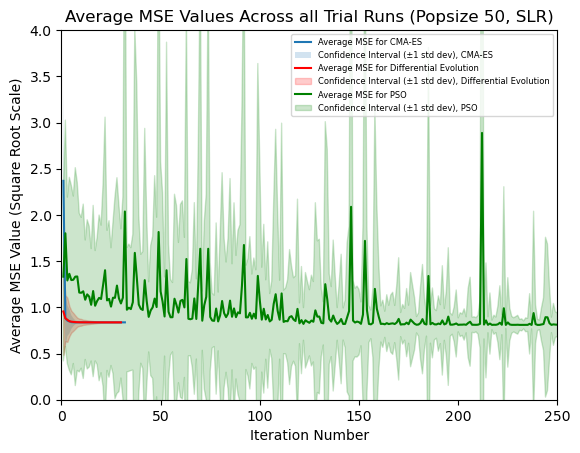

In [18]:
CMA_SLR_50 = pd.read_csv('CMAES_SLR_mses_pop_50.csv')
DE_SLR_50 = pd.read_csv('DE_SLR_mses_pop_50.csv')
PSO_SLR_50 = pd.read_csv('PSO_SLR_mses_pop_50.csv')
plot_mses_new(CMA_SLR_50, DE_SLR_50, PSO_SLR_50, ['CMA-ES', 'Differential Evolution', 'PSO'], 'SLR', 50)

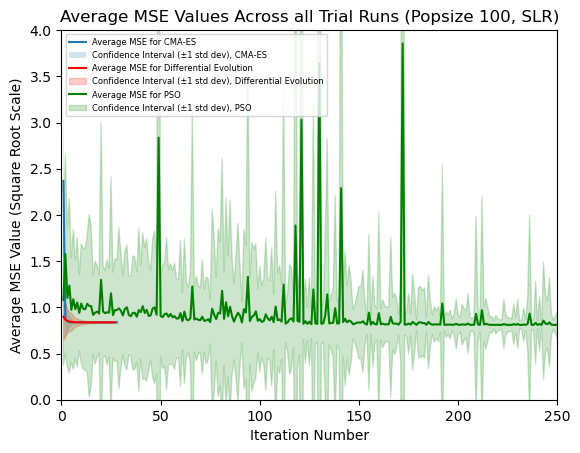

In [19]:
CMA_SLR_100 = pd.read_csv('CMAES_SLR_mses_pop_100.csv')
DE_SLR_100 = pd.read_csv('DE_SLR_mses_pop_100.csv')
PSO_SLR_100 = pd.read_csv('PSO_SLR_mses_pop_100.csv')
plot_mses_new(CMA_SLR_100, DE_SLR_100, PSO_SLR_100, ['CMA-ES', 'Differential Evolution', 'PSO'], 'SLR', 100)

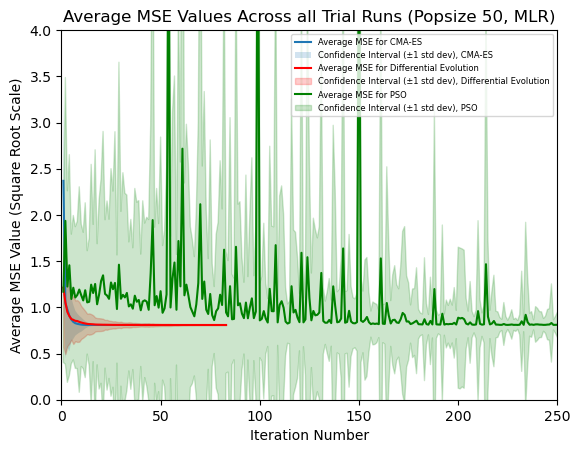

In [20]:
CMA_MLR_50 = pd.read_csv('CMAES_MLR_mses_pop_50.csv')
DE_MLR_50 = pd.read_csv('DE_MLR_mses_pop_50.csv')
PSO_MLR_50 = pd.read_csv('PSO_MLR_mses_pop_50.csv')
plot_mses_new(CMA_MLR_50, DE_MLR_50, PSO_MLR_50, ['CMA-ES', 'Differential Evolution', 'PSO'], 'MLR', 50)

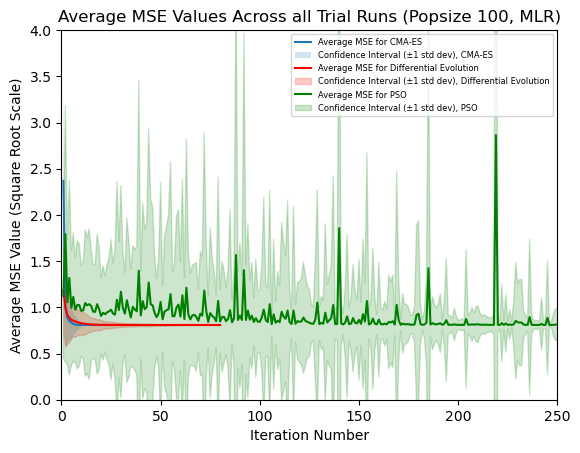

In [21]:
CMA_MLR_100 = pd.read_csv('CMAES_MLR_mses_pop_100.csv')
DE_MLR_100 = pd.read_csv('DE_MLR_mses_pop_100.csv')
PSO_MLR_100 = pd.read_csv('PSO_MLR_mses_pop_100.csv')
plot_mses_new(CMA_MLR_100, DE_MLR_100, PSO_MLR_100, ['CMA-ES', 'Differential Evolution', 'PSO'], 'MLR', 100)

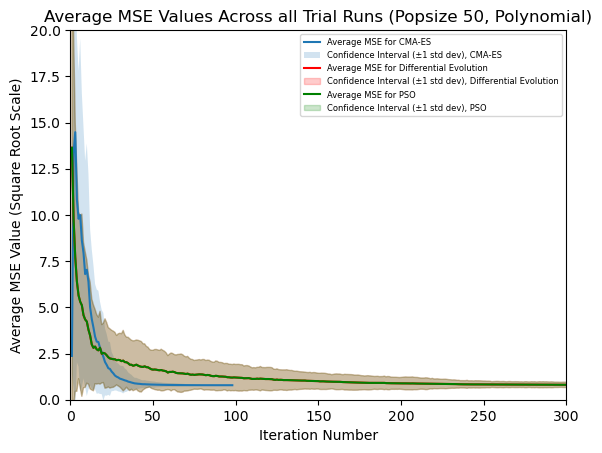

In [22]:
CMA_Poly_50 = pd.read_csv('CMAES_Poly_mses_pop_50.csv')
DE_Poly_50 = pd.read_csv('DE_Poly_mses_pop_50.csv')
PSO_Poly_50 = pd.read_csv('DE_Poly_mses_pop_50.csv')
plot_mses_new(CMA_Poly_50, DE_Poly_50, PSO_Poly_50, ['CMA-ES', 'Differential Evolution', 'PSO'], 'Polynomial', 50)

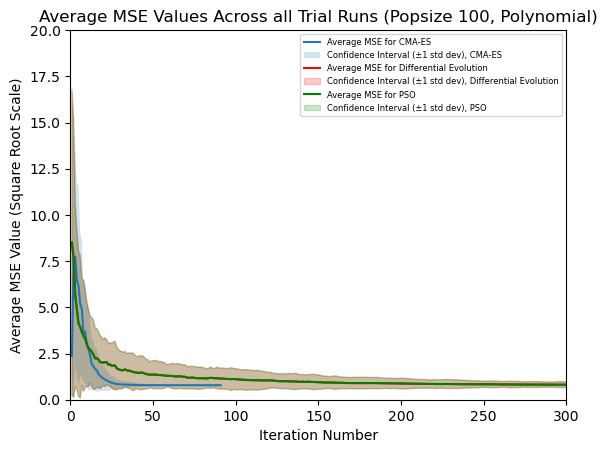

In [23]:
CMA_Poly_100 = pd.read_csv('CMAES_Poly_mses_pop_100.csv')
DE_Poly_100 = pd.read_csv('DE_Poly_mses_pop_100.csv')
PSO_Poly_100 = pd.read_csv('DE_Poly_mses_pop_100.csv')
plot_mses_new(CMA_Poly_100, DE_Poly_100, PSO_Poly_100, ['CMA-ES', 'Differential Evolution', 'PSO'], 'Polynomial', 100)